In [ ]:
#|hide
from nbdev import *

# VASP Tutorial
> This example uses VASP to calculate forces and energies. This is a non-free calculator which needs to be installed/setup separately. This example can be easily adapted to some other DFT calculator (e.g. QuantumEspresso, AbInit etc.)

## Setup

First we need to setup the environment by importing required tools from ASE, stadlib tqdm and hecss libraries.

In [ ]:
#|vasp
# Import VASP calculator and unit modules
from ase.calculators.vasp import Vasp
from ase import units as un
from os.path import isfile
import os

# The sample generator, monitoring display and dfset writer
from hecss import HECSS
from hecss.util import write_dfset
from hecss.monitor import plot_stats

# Numerical and plotting routines
import numpy as np
from matplotlib import pyplot as plt

## System setup

You can run more realistic test using 2x2x2 (or even larger) supercell. The results generated by such calculation are included in the `example/VASP_3C-SiC_calculated` directory in the source tree. You can run post-processing on these results and use them as a reference. By changing the value of the `supercell` variable:
```python
supercell = '2x2x2'
```
you can run a more realistic calculations. If you want to run your own calulation be prepared for some substantial computational resources required for such a job. A single 2x2x2 job takes 2-5 minutes on the 64-core computing node. Better test first with single unit cell setup. For this tutorial we will run with very small system - just a single unit cell of 3C-SiC crystal.

In [ ]:
#|vasp
# Quick test using conventional unit cell
supercell = '1x1x1'

In [ ]:
#|vasp
# Directory in which our project resides
base_dir = f'example/VASP_3C-SiC/{supercell}/'

## Calculator setup

You need to configure your own environment for VASP. The `run-calc` script located in the root directory is an example from my own system. You need to modify it to fit your system.
Running `run-calc` in a given directory should submit a VASP job to your cluster *and* wait for it to end. Example of such job script from my system (small cluster with SLURM job menager) is included in `example/scripts` directory.

In [ ]:
#| vasp
# Read the structure (previously calculated unit(super) cell)
# The command argument is specific to the cluster setup
calc = Vasp(label='cryst', directory=f'{base_dir}/sc_{supercell}/', restart=True)

# This just makes a copy of atoms object
# Do not generate supercell here - your atom ordering will be wrong!
cryst = calc.atoms.repeat(1)

If you have magmoms in your system you need to use following 
temporary fix for a bug in magmom handling in Vasp2 calculator:
```python
if 'magmom' in calc.list_float_params:
    calc.list_float_params['magmom'] = cryst.get_initial_magnetic_moments()
```
Just copy the above code to a new cell here and execute it.

In [ ]:
#|vasp
# Setup the calculator - single point energy calculation
# The details will change here from case to case
# We are using run-vasp from the current directory!
calc.set(directory=f'TMP/calc_{supercell}/sc')
calc.set(command=f'{os.getcwd()}/run-calc.sh "3C-SiC-{supercell}"')
calc.set(nsw=0)
cryst.set_calculator(calc)

## System check

You should probably check the calculator setup and the stress tensor of the supercell to make sure it is in equilibrium before running long sequence of DFT calculations. Here is an example:

In [ ]:
#|vasp
print('Stress tensor: ', end='')
for ss in calc.get_stress()/un.GPa:
    print(f'{ss:.3f}', end=' ')
print('GPa')

Stress tensor: 0.017 0.017 0.017 0.000 0.000 0.000 GPa


## Running HECSS

There are multiple ways you can use HECSS to generate samples -- depending from the stage your project is, your familiarity with python language and sophistication required by your project. 

You would probably start with more exploratory setup when you start the project and do not know yet the behaviour of the system. It is best to start with small structure, small initial number of samples and code structure which allows for iterating by returning to the same calculation to generate more samples or breaking the loop which goes wrong. This type of calculation may be well served by the code like the following example:

In [ ]:
#|vasp
# Space for results
xsl = []
calc_dir = f'TMP/calc_{supercell}'

In [ ]:
#|vasp
# Build the sampler
hecss = HECSS(cryst, calc, 
              directory=f'{calc_dir}',
              w_search = True,
              pbar=True,
              # reuse_base=f'{base_dir}/calc/' # Use if you want to reuse the base calc
              )

  0%|          | 0/10 [00:00<?, ?it/s]

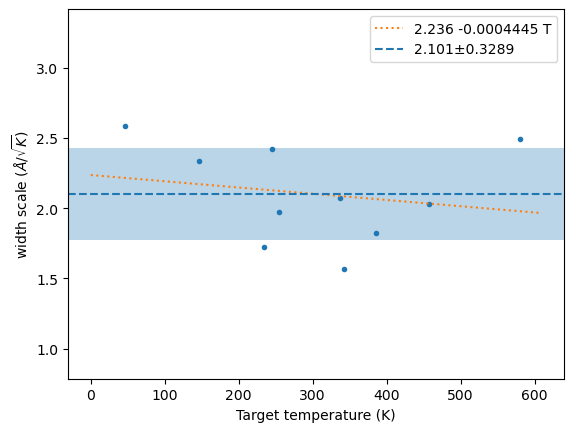

In [ ]:
#|vasp
m, s, wm = hecss.estimate_width_scale(10, wm_out=True)

y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plt.plot(wm[1], y, '.');
x = np.linspace(0, 1.05*wm[1].max(), 2)
fit = np.polyfit(wm[1], y, 1)
plt.plot(x, np.polyval(fit, x), ':', label=f'{fit[1]:.4g} {fit[0]:+.4g} T')
plt.axhline(m, ls='--', label=f'{m:.4g}±{s:.4g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.ylim(m-4*s, m+4*s)
plt.xlabel('Target temperature (K)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.legend();

In [ ]:
#|vasp
# Temperature (K)
T = 300

In [ ]:
#|vasp
# Desired number of samples.
# Here 4 is minimal in 3C-SiC 
# to get somewhat decent phonons 
# with 10 Bohr cutoff.
N = 4

In [ ]:
#|vasp
samples = hecss.sample(T, N)

  0%|          | 0/4 [00:00<?, ?it/s]

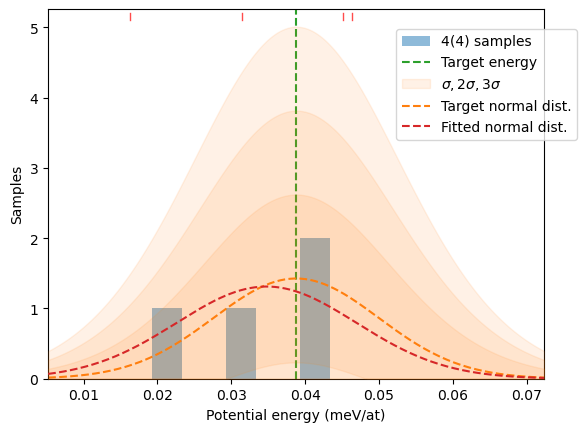

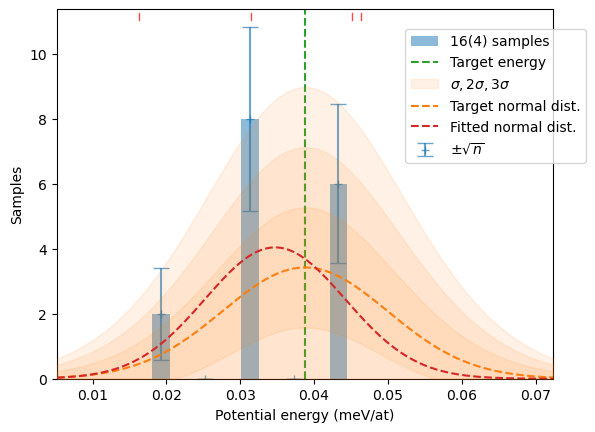

In [ ]:
#|vasp
plot_stats(samples, T)
distrib = hecss.generate(samples, T)
plot_stats(distrib, T, sqrN=True)

After the first run you can increase the limit (N) and return to the same loop (the state of the sampler is preserved) to generate more samples. This cell can be executed multiple times to collect enough samples for further analysis. You can also monitor the progress by providing `sentinel` argument to the `generate` method. Here is a simple monitoring function showing an updated histogram and position of the last sample (as dotted line)

In [ ]:
#|vasp
def show_stats(s, sl, col=None, Temp=None):
    from matplotlib import pyplot as plt
    from IPython.display import clear_output
    from hecss.optimize import make_sampling
    plot_stats(make_sampling(sl if col is None else col + sl, Temp), 
               Temp, show=False)
    plt.axvline(s[-1], ls=':', label='Last sample')
    plt.legend()
    plt.show()
    clear_output(wait=True)
    # Important! Return False to keep iteration going
    return False

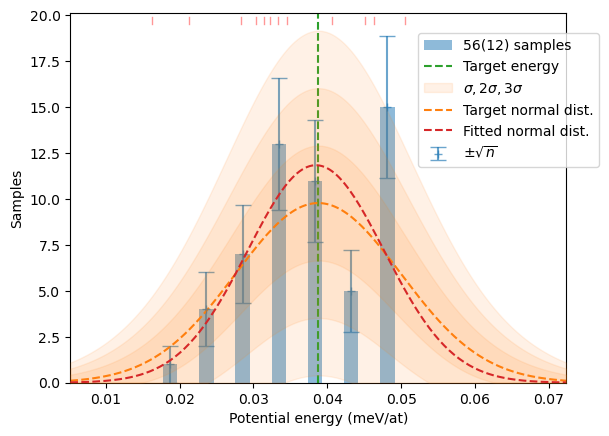

In [ ]:
#|vasp
# Need more samples. Increase N and get more samples.
N = 10
samples += hecss.sample(T, N, sentinel=show_stats, 
                              sentinel_args={'col':samples, 'Temp':T})
plot_stats(hecss.generate(samples, T), T, sqrN=True)

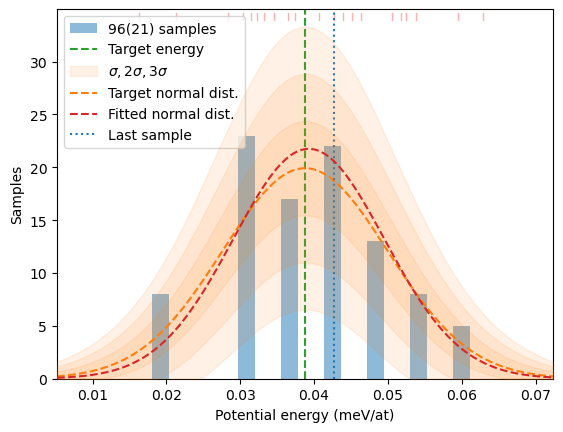

In [ ]:
#|vasp
samples += hecss.sample(T, N, sentinel=show_stats, 
                              sentinel_args={'col':samples, 'Temp':T})

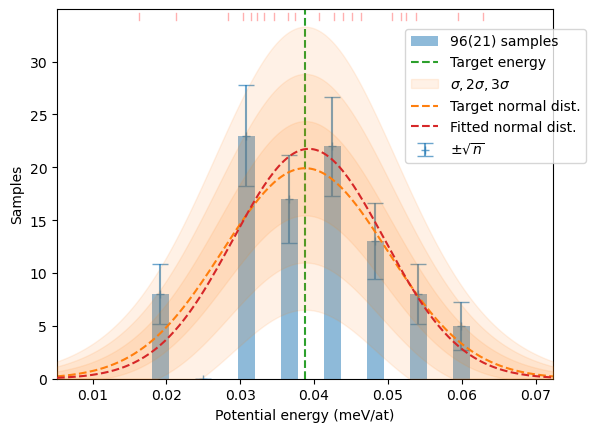

In [ ]:
#|vasp
# Verify if we really got the same picture
plot_stats(hecss.generate(samples, T), T, sqrN=True)

In [ ]:
#|vasp
for c in samples:
    write_dfset(f'{calc_dir}/DFSET_T={T}K.dat', c)

When you are at production stage of your project and you know exactly what you want and how to get it the more compact style of code may be better. Though, it is less elastic and forgiving of mistakes. Here is a similar sampling run at T=600 K.

  0%|          | 0/50 [00:00<?, ?it/s]

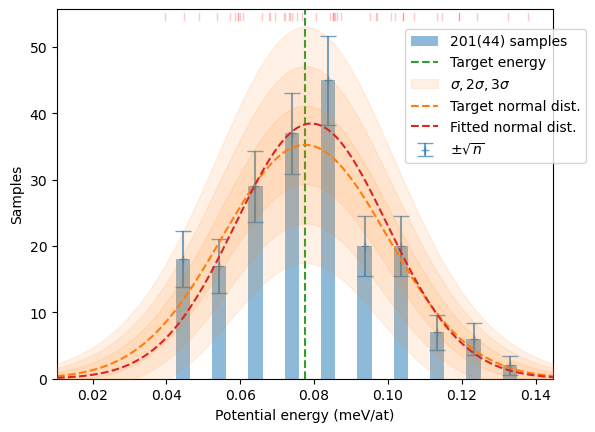

In [ ]:
#|vasp
T=600
confs_600 = hecss.sample(T, 50)
plot_stats(hecss.generate(confs_600, T), T, sqrN=True)

In [ ]:
#|vasp
for c in confs_600:
    write_dfset(f'{calc_dir}/DFSET_T={T}K.dat', c)